TOF = DIFC \* d + DIFA \* d^2 + TZERO

$ tof = (L1+L2)/v $

$ k = 0.0015882549421289758 \times v $

$ 2d sin(\theta) = \lambda $

$ \lambda = \frac{2\pi}{k} $

$ tof = (L1+L2)/(2\pi) \; 2d \; sin(\theta) \times 0.0015882549421289758 $

$ DIFC = (L1+L2)/(\pi) \; sin(\theta) \times 0.0015882549421289758 \times 10^6 $

# Calibration for Powder Diffraction
There are two general interfaces used for calibrating instruments for powder diffraction that are covered in this tutorial
* [Calibration Information](#Calibration-Information)
* [PDCalibration](#PDCalibration)

The tutorial also covers information about masking calibration files

In [1]:
# setup plotting
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
# plt.xkcd() # comment this out for serious science
# plt.rcdefaults()
# useful modules
import os
# ...and, of course, mantid
from mantid.simpleapi import *

In [3]:
import numpy as np
from mantid import simpleapi as msa

## Calibration Information
For all of the calibrations there needs to be a "known" lattice constant to calibrate against when determining the tof to dspacing conversion factors. Traditionally at SNS diamond is used for this. Mantid has a facility for [crystal structure and reflections](http://docs.mantidproject.org/nightly/concepts/CrystalStructureAndReflections.html) built in.

In [4]:
from mantid.geometry import CrystalStructure, ReflectionGenerator

In [5]:
latticeConstants = ['5.43102' for i in xrange(3)] # 
Si = CrystalStructure(' '.join(latticeConstants),
                           "F d -3 m", "Si 0 0 0 1.0 0.05")
generator = ReflectionGenerator(Si)
dvalues = generator.getDValues(generator.getUniqueHKLs(.4,4.))
print dvalues

[3.1356,1.92016,1.5678,1.63751,1.24596,1.0452,1.35776,1.1086,0.960078,0.90517,0.7839,1.0452,0.91801,0.828223,0.760495,0.707059,0.62712,0.85872,0.818757,0.725751,0.658608,0.640052,0.622981,0.578949,0.5226,0.760495,0.707059,0.663505,0.62712,0.596132,0.545838,0.545838,0.525037,0.489699,0.447943,0.678878,0.640052,0.607206,0.592573,0.554301,0.532555,0.504258,0.465706,0.480039,0.47271,0.452585,0.424091,0.596132,0.569326,0.545838,0.525037,0.506445,0.47451,0.47451,0.460653,0.43623,0.405933,0.42539,0.41532,0.532555,0.5226,0.495782,0.47271,0.465706,0.459005,0.440514,0.414111,0.419012,0.404804,0.489699,0.47451,0.460653,0.447943,0.43623,0.41532,0.41532,0.405933,0.452585,0.440514,0.42936,0.424091,0.409379,0.40038,0.41532,0.405933]


In [6]:
dvalues = np.array(dvalues)
dvalues = np.array(dvalues*1e8, dtype=int)/1e8
dvalues = np.unique(dvalues)
dvalues

array([ 0.4003801 ,  0.40480433,  0.40593349,  0.40937853,  0.41411139,
        0.41532047,  0.41901228,  0.42409141,  0.42539031,  0.42935983,
        0.43623002,  0.44051389,  0.44794297,  0.452585  ,  0.45900496,
        0.4606531 ,  0.46570612,  0.47270961,  0.47451042,  0.48003888,
        0.48969858,  0.49578202,  0.50425754,  0.50644522,  0.52260014,
        0.52503652,  0.53255532,  0.54583804,  0.55430115,  0.56932559,
        0.57894867,  0.59257286,  0.59613189,  0.60720649,  0.62298071,
        0.62712017,  0.64005184,  0.65860791,  0.66350469,  0.6788775 ,
        0.70705857,  0.72575057,  0.76049491,  0.78390021,  0.81875707,
        0.82822278,  0.85871966,  0.90517   ,  0.91800993,  0.96007776,
        1.04520028,  1.10860231,  1.24596143,  1.357755  ,  1.56780042,
        1.63751414,  1.92015553,  3.13560085])

### Get d values from exp data

Load data

In [7]:
%%time
wkspName='SEQ_130273'

LoadEventAndCompress(Filename="/SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5", OutputWorkspace=wkspName,
                     MaxChunkSize=16, FilterBadPulses=25)
CropWorkspace(InputWorkspace=wkspName, OutputWorkspace=wkspName, XMin=300, XMax=16666.7)

CPU times: user 6min, sys: 5min 30s, total: 11min 31s
Wall time: 5min 5s


In [39]:
# mtd.getObjectNames()

Convert to I(d)

In [8]:
%%time
I_d = msa.ConvertUnits(InputWorkspace=wkspName, Target='dSpacing', EMode='Elastic')

CPU times: user 7.73 s, sys: 6.1 s, total: 13.8 s
Wall time: 13.8 s


In [9]:
%%time
I_d = msa.Rebin(InputWorkspace=I_d, Params='0.4,0.0005,7')

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 117 ms


In [10]:
%%time
I_d_s = msa.SumSpectra(InputWorkspace=I_d)

CPU times: user 5.14 s, sys: 13.2 s, total: 18.4 s
Wall time: 18.4 s


In [43]:
# mtd.getObjectNames()

Plot

<IPython.core.display.Javascript object>


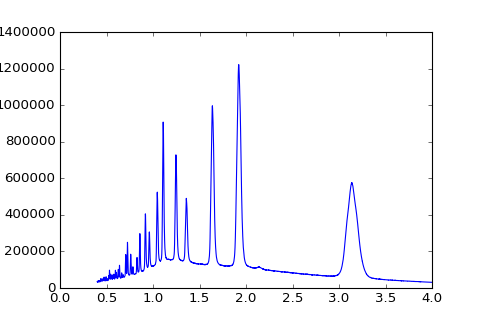

(0, 4)

In [12]:
plt.figure(figsize=(6,4))
plt.plot(I_d_s.readX(0)[:-1], I_d_s.readY(0))
plt.xlim(0,4)

In [13]:
dvalues

array([ 0.4003801 ,  0.40480433,  0.40593349,  0.40937853,  0.41411139,
        0.41532047,  0.41901228,  0.42409141,  0.42539031,  0.42935983,
        0.43623002,  0.44051389,  0.44794297,  0.452585  ,  0.45900496,
        0.4606531 ,  0.46570612,  0.47270961,  0.47451042,  0.48003888,
        0.48969858,  0.49578202,  0.50425754,  0.50644522,  0.52260014,
        0.52503652,  0.53255532,  0.54583804,  0.55430115,  0.56932559,
        0.57894867,  0.59257286,  0.59613189,  0.60720649,  0.62298071,
        0.62712017,  0.64005184,  0.65860791,  0.66350469,  0.6788775 ,
        0.70705857,  0.72575057,  0.76049491,  0.78390021,  0.81875707,
        0.82822278,  0.85871966,  0.90517   ,  0.91800993,  0.96007776,
        1.04520028,  1.10860231,  1.24596143,  1.357755  ,  1.56780042,
        1.63751414,  1.92015553,  3.13560085])

Compare these with the plot, we just pick the few peaks with large intensities. 

In [17]:
dvalues1 = list(dvalues[-7:])
del dvalues1[3]

In [18]:
print dvalues1

[1.10860231, 1.2459614299999999, 1.357755, 1.63751414, 1.9201555299999999, 3.1356008499999999]


[PDCalibration](http://docs.mantidproject.org/nightly/algorithms/PDCalibration-v1.html)
-------------------------------------

In [26]:
PDCalibration?

In [19]:
dvalues1

[1.10860231,
 1.2459614299999999,
 1.357755,
 1.63751414,
 1.9201555299999999,
 3.1356008499999999]

In [4]:
dvalues1 = [1.10860231,
 1.2459614299999999,
 1.357755,
 1.63751414,
 1.9201555299999999,
 3.1356008499999999]

In [ ]:
signal = Load('/SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5')

In [21]:
%%time
# generates a workspace of delta-d/d which could be used to estimate uncertainties
#EstimateResolutionDiffraction(InputWorkspace=wkspName, OutputWorkspace='resolution', DeltaTOF=5)

# start from a previous calibration
# oldCal=calib_path

PDCalibration(
    SignalWorkspace="signal",
    TofBinning=[300,-.001,16666.7],
    # PreviousCalibration=oldCal,
    PeakPositions=dvalues1,
    StartFromObservedPeakCentre=True,
    OutputCalibrationTable='new_cal',
    DiagnosticWorkspaces='cal_diag',
    CalibrationParameters='DIFC')

CPU times: user 2h 52min 46s, sys: 5min 58s, total: 2h 58min 44s
Wall time: 5min 54s


PDCalibration_returns(OutputCalibrationTable=TableWorkspace
Columns: 6
Rows: 115712
4 MB, DiagnosticWorkspaces=WorkspaceGroup
 -- cal_diag_dspacing
, MaskWorkspace=Title: 
Histograms: 115712
Masked: 9039
)

In [22]:
cal_diag = mtd['cal_diag']
cal_diag_d = cal_diag[0]
cal_diag_d.getColumnNames()

['detid',
 '@1.1086',
 '@1.246',
 '@1.3578',
 '@1.6375',
 '@1.9202',
 '@3.1356',
 'chisq',
 'normchisq']

In [23]:
d16375 = np.array(cal_diag_d.column('@1.6375'))
d16375[d16375==d16375]

array([ 1.57796941,  1.62423854,  1.59250955, ...,  1.63863526,
        1.63891642,  1.64051171])

In [24]:
d11086 = np.array(cal_diag_d.column('@1.1086'))
d11086[d11086==d11086]

array([ 1.1086023 ,  1.1086023 ,  1.10860232, ...,  1.10675709,
        1.10880647,  1.10712426])

In [25]:
d31356 = np.array(cal_diag_d.column('@3.1356'))
d31356[d31356==d31356]

array([ 3.13405607,  3.11917082,  3.13105388, ...,  3.07454675,
        3.04176452,  3.04332469])

In [47]:
tmp = d31356[100352:101375+1]

In [52]:
tmp[14]

3.1356008788977063

In [49]:
np.average(tmp[tmp==tmp])

3.1354436230638076

In [63]:
d31356[100455]

3.1356009137224281

In [26]:
chisq = np.array(cal_diag_d.column('normchisq'))

In [27]:
chisq.size

115712

In [54]:
chisq[100366]

0.0022562644213507664

In [34]:
chisq[chisq>.003].size

2267

In [60]:
w = np.array(np.where(np.logical_and(chisq < 0.00001, chisq>0))[0])

In [61]:
w[w>100352]

array([100455, 100456, 100460, ..., 115705, 115706, 115708])

In [62]:
chisq[100455]

9.2688686621877604e-06

In [35]:
mask_difc = chisq>0.003
np.save("mask_difc.npy", mask_difc)

<IPython.core.display.Javascript object>


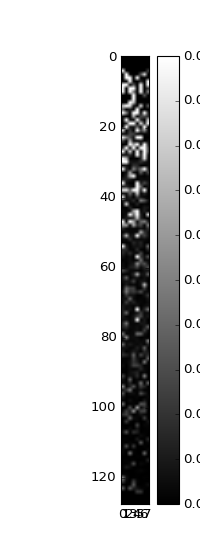

In [33]:
d23_chisq = chisq[100352: 101376]
d23_chisq.shape = 8, 128
plt.figure(figsize=(2.5, 7))
plt.imshow(d23_chisq.T, cmap='gray')
plt.clim(0, 0.003)
plt.colorbar()

In [126]:
d23_chisq[d23_chisq > 1e-2]

array([ 0.01452051,  0.01292165,  0.01247853,  0.01155825,  0.02027359,
        0.05785221,  0.01202104,  0.02594932,  0.02614669,  0.01183333,
        1.48892556,  0.07063846,  0.03262999,  0.0262667 ,  0.01294928,
        0.07111781,  0.12133693,  0.01979089,  0.01370043,  0.01058252,
        0.01118602,  0.010367  ,  0.39629389,  0.32389607,  0.02632969,
        0.52909547,  0.31776521,  0.32059385,  0.17921347,  0.04080708,
        0.12805122,  0.01028794,  0.23511364,  1.54290048,  0.4085852 ,
        0.01488002,  0.23060468])

In [36]:
new_cal = mtd['new_cal']

In [45]:
msa.SaveNexus('new_cal', './difc_cal.nxs')

In [37]:
new_cal.row(0)

{'detid': 37888,
 'difa': 0.0,
 'difc': 6687.009162989168,
 'tofmax': 1.7976931348623157e+308,
 'tofmin': 0.0,
 'tzero': 0.0}

In [38]:
new_cal.row(1000)

{'detid': 38888,
 'difa': 0.0,
 'difc': 6292.301400544343,
 'tofmax': 1.7976931348623157e+308,
 'tofmin': 0.0,
 'tzero': 0.0}

In [39]:
L1 = 20.
L2 = 6. # approx
# assume sin(\theta) = 1.
DIFC = (L1+L2)/np.pi * 1. * 0.0015882549421289758 * 1e6
print DIFC

13144.4884964


This does not look all wrong

In [40]:
new_cal.getColumnNames()

['detid', 'difc', 'difa', 'tzero', 'tofmin', 'tofmax']

In [41]:
new_cal.rowCount()

115712

In [42]:
tzero = np.array(new_cal.column('tzero'))

In [43]:
tzero[tzero!=0]

array([], dtype=float64)

In [44]:
tzero[5106]

0.0

In [64]:
ls

align components.ipynb              runs.txt
align components - try1.ipynb       SEQ_calibrate_d130271_2017_09_18.cal
align_comp.py*                      SEQ_calibrate_d130271_2017_09_18.h5
align_comp.py~*                     SEQ_calibrate_d130271_2017_09_19.cal
#align.py#                          SEQ_calibrate_d130271_2017_09_19.h5
align.py                            SEQ_new.xml
align.pyc                           SEQ_new.xml~
check.ipynb                         SEQUOIA_Definition.xml
difc_cal.nxs                        Si-difc.ipynb
L2table.nxs                         Si-diffc-try1.ipynb
log.align_comp                      Si-diffc-try2a.ipynb
mask_difc.npy                       V-L2_explore1.ipynb
new.xml                             V-L2.ipynb
PDCalibration-d spacing test.ipynb


In [114]:
%%time
LoadEventAndCompress(Filename="/SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5", OutputWorkspace=wkspName,
                     MaxChunkSize=16, FilterBadPulses=25)
CropWorkspace(InputWorkspace=wkspName, OutputWorkspace=wkspName, XMin=300, XMax=16666.7)

# dbinning=(.01,-.001,4.)
dbinning = (0.4,0.00005,7)
AlignDetectors(InputWorkspace=wkspName, OutputWorkspace='aligned', CalibrationWorkspace='new_cal')
CropWorkspace(InputWorkspace='aligned', OutputWorkspace='aligned',
              XMin=dbinning[0], XMax=dbinning[2])
Rebin(InputWorkspace='aligned', OutputWorkspace='aligned', Params=dbinning)

CPU times: user 7min 2s, sys: 3min 6s, total: 10min 9s
Wall time: 6min 34s


In [78]:
%%time
msa.SumSpectra(InputWorkspace='aligned', OutputWorkspace='I_d_s_aligned')

CPU times: user 5.51 s, sys: 1min 25s, total: 1min 31s
Wall time: 1min 37s


EventWorkspace
Title: Si powder, White beam, Ei set to 250meV T0=30
Histograms: 1
Bins: 5995
Histogram
X axis: d-Spacing / Angstrom
Y axis: Counts
Distribution: False
Instrument: SEQUOIA (2012-Apr-04 to 2100-Jan-31)Instrument from: /SNS/SEQ/IPTS-19573/nexus/SEQ_130271.nxs.h5

Parameters from: /home/lj7/dv/mantid/mantid/instrument/SEQUOIA_Parameters.xml
Run start: 2017-Jul-14 04:26:01
Run end:  2017-Jul-14 06:21:57

Events: 838864418 (weighted, no times)

<IPython.core.display.Javascript object>


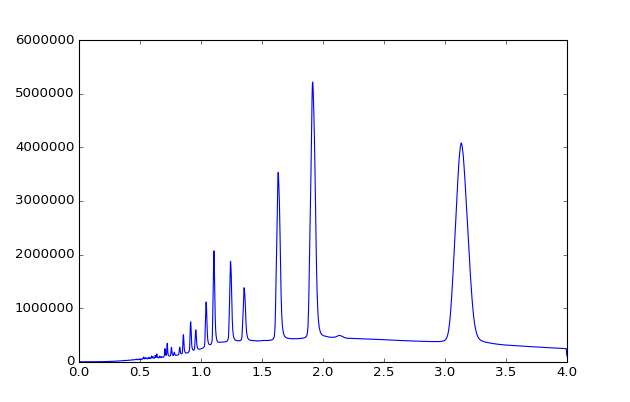

In [79]:
ws = I_d_s_aligned = mtd['I_d_s_aligned']
plt.plot(ws.readX(0)[:-1], ws.readY(0))